# Sistema evolutivo basado en reglas para regresión

### Descripción

<font size="4"> Algoritmo evolutivo para regresión basada en reglas.

### Componentes
    
- <font size="3"> Datos:
    
    - <font size="3"> Regresión

    - <font size="3"> Entradas numéricas y categóricas
    
- <font size="3"> Algoritmo evolutivo (minimiza mse):
    
    - <font size="3"> Número de reglas fijo, enfoque Pittsburgh 
    
    - <font size="3"> Representación con parámetros reales, categóricos y binarios 

    - <font size="3"> Selección por torneo binario

    - <font size="3"> Sustitución $(\mu+\lambda)$ 

    - <font size="3"> Elitismo    

    - <font size="3"> Cruce uniforme, aritmético y SBX

    - <font size="3"> Mutación uniforme, small, polinomial y bit-flip

### Comentarios
    
- <font size="3"> Se requiere ordenar una población de $2 \cdot N$ individuos con los $\mu$ padres más los $\lambda$ hijos, $\mu=\lambda=N$.
    
---

### Requerimientos

In [18]:
import numpy as np
import heapq 
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

### Lectura de los datos

#### Input:
  - $file\_path$: Nombre completo con path de la base de datos .arff a cargar
  
#### Output:
- $values$: Valores
    - $X$: Atributos de entrada numéricos y categóricos:
        - $a$: Atributos de entrada numéricos
        - $b$: Atributos de entrada categóricos
    - $y$: Salida numérica    
- $bounds$: Límites
    - $LR$: Límites inferiores de los atributos de entrada numéricos
    - $UR$: Límites superiores de los atributos de entrada numéricos
    - $UC$: Límites superiores de los atributos de entrada categóricos
    - $LS$: Límite inferior de la salida
    - $US$: Límite superior de la salida
- $names$: Nombres
    - $Sr$: Nombres de los atributos numéricos
    - $Sc$: Nombres de los atributos categóricos
    - $S$: Nombre de la salida
    - $E$: Etiquetas de las clases de los atributos categóricos

In [2]:
def LoadData(file_path):

    data,meta = arff.loadarff(file_path)

    # Convertir a DataFrame
    df = pd.DataFrame(data)

    # Separar en entradas (a,b) y salida (y)
    df_input = df.iloc[:, :-1]              # Entradas: (a,b)
    y = df.iloc[:, -1]                      # Salidas: y (la última columna)

    # Valores de salida    
    LS = np.array([np.min(y)]) # Límite inferior
    US = np.array([np.max(y)]) # Límite superior

    # Número de instancias
    w = data.size

    # Nombres los atributos numéricos (Sr), categóricos (Sc) y salida (S)
    Sr = df_input.select_dtypes(include=['float']).columns  
    Sc = df_input.select_dtypes(include=['object']).columns 
    S = df.columns[-1]

    # Número de attributos numéricos (n) y categóricos (m)
    n = Sr.size
    m = Sc.size

    # Atributos numéricos
    a = np.zeros((w,n), dtype=float)
    LR = np.zeros(n, dtype=float)
    UR = np.zeros(n, dtype=float)
    if (n>0):
        a = SimpleImputer(strategy='mean').fit_transform(df[Sr])  # Los datos que falten se sustituyen con la media
        a = np.array(a)
        LR = np.min(a, axis=0) # Límite inferior
        UR = np.max(a, axis=0) # Límite superior

    # Atributos categóricos
    b = np.zeros((w,m), dtype=int)
    UC = np.zeros(m, dtype=int)    
    E = []
    if (m>0):
        b = SimpleImputer(strategy='most_frequent').fit_transform(df[Sc]) # Los datos que falten se sustituyen con la moda
        index = 0
        for l in Sc:            
            class_values = meta._attributes[l].range
            le = LabelEncoder()
            le.fit(class_values)
            b_i = [label.decode('utf-8') for label in b[:,index]]
            b[:,index] = le.transform(b_i)
            index += 1
        E = [ meta._attributes[l].range for l in Sc]  # Nombres de las etiquetas de los atributos categóricos de entrada
        UC = np.max(b, axis=0) # Límite superior        
        
    X = np.hstack((a, b))
    values = X,y
    
    bounds = LR,UR,UC,LS,US
    names = Sr,Sc,S,E
    
    return values,bounds,names

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones
- $N$: Tamaño de la población
- $M$: Número de reglas del modelo
- $random\_state$: Semilla para reproducibilidad
- $bounds$: Límites de los datos
- $X,y$: Datos
- $prob$: Probabilidades
  - $prob\_cross$: Probabilidades de cruce
    - $p\_c$: Probabilidad de cruce
    - $uniform\_crossover\_probability$: Probabilidad de cruce uniforme
    - $arithmetic\_crossover\_probability$: Probabilidad de cruce aritmético
    - $SBX\_crossover\_probability$: Probabilidad de cruce SBX
  - $prob\_mutation$: Probabilidades de mutación
    - $p\_m$: Probabilidad de mutación
    - $uniform\_mutation\_probability$: Probabilidad de mutación uniforme 
    - $small\_mutation\_probability$: Probabilidad de mutación small 
    - $polynomial\_mutation\_probability$: Probabilidad de mutación small 
    - $epsilon$: Máximo cambio en mutación small
    - $p\_m\_binary$: Probabilidad de mutación binaria

In [3]:
G = 100
N = 100
M = 4
random_state = 1

file_path = "./DATASETS/ICU_train.arff"

data = LoadData(file_path)
values,bounds,names = data
X,y = values

p_c = 0.7
uniform_crossover_probability = 0.4 
arithmetic_crossover_probability = 0.2
SBX_crossover_probability = 0.4

p_m = 0.1
uniform_mutation_probability = 0.4
small_mutation_probability = 0.2
polynomial_mutation_probability = 0.4
epsilon = 1e-6

p_m_binary                       = 0.1

prob_cross = p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability
prob_mutation = p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon,p_m_binary
prob = prob_cross,prob_mutation

### Definición del individuo

In [4]:
class Solucion:
    def __init__(self,M,n,m):
        
        # Condiciones asociadas a los atributos de entrada numéricos
        self.AL = np.zeros((M, n)) # Límites inferiores
        self.AU = np.zeros((M, n)) # Límites superiores
        self.aL = np.zeros((M, n),dtype=int) # Máscara de activación de los límites inferiores
        self.aU = np.zeros((M, n),dtype=int) # Máscara de activación de los límites superiores
        
        # Condiciones asociadas a los atributos de entrada categóricas        
        self.BB = np.zeros((M, m),dtype=int) # Valor de las condiciones asociadas a los atributos de entrada categóricos
        self.bB = np.zeros((M, m),dtype=int) # Valor de la condición
        
        # Valores de salida predichos por las reglas
        self.S = np.zeros((M,1))
        
class Individuo:    
    def __init__(self,M,n,m):
        self.x = Solucion(M,n,m)
        self.f = 0.0         
    def __lt__(self, ind):
        return self.f < ind.f

### Inicialización de la población

In [5]:
def InitializePopulation(P,bounds):
    M = P[0].x.AL.shape[0]
    LR,UR,UC,LS,US = bounds
    n = LR.size
    m = UC.size
    for I in P:
        I.x.AL[:] = np.random.uniform(LR, UR, (M, n)) 
        I.x.AU[:] = np.random.uniform(LR, UR, (M, n)) 
        I.x.aL[:] = np.random.randint( 0,  2, (M, n)) 
        I.x.aU[:] = np.random.randint( 0,  2, (M, n))         
        I.x.BB[:] = np.random.randint( 0, UC, (M, m)) 
        I.x.bB[:] = np.random.randint( 0,  2, (M, m))    
        I.x.S[:]  = np.random.uniform(LS, US, (M, 1))

### Reparo

In [6]:
def repair(I):
    mask = I.x.AL > I.x.AU
    I.x.AL[mask], I.x.AU[mask] = I.x.AU[mask], I.x.AL[mask]

### Función de evaluación

$\textit{Minimizar} \ f(\textbf{x}) = MSE(\textbf{x},D,\Phi)$
- $\textbf{x}=\{x_1,\ldots,x_n\}$: Parámetros del modelo de reglas
- $D = (X,y)$: Dataset
- $\Phi: $ Modelo de reglas definido en $\textbf{x}$

Usa las siguientes funciones:
- $fire\_strength$: Función de disparo
    - Devuelve la fuerza de disparo del modelo para un dato
- $predict\_ind$: Función de predicción
    - Devuelve el valor predicho por el modelo para un dato

In [7]:
def fire_strength(x,X,bounds):
    M = x.AL.shape[0]
    n = x.AL.shape[1]
    m = x.BB.shape[1]
    w = X.shape[0]
    a = X[:, :n]
    b = X[:,n:]        
    LR,UR,UC,LS,US = bounds
    fire = np.zeros((w,M))
    for t in range(w):
        for k in range(M):
            fire[t][k] = 1.0
            # Disparo para variables numéricas
            for l in range(n):                
                if x.aL[k][l]==1 and a[t][l]<x.AL[k][l]:
                    fire[t][k] *= 1-(x.AL[k][l]-a[t][l])/(UR[l]-LR[l])
                if x.aU[k][l]==1 and a[t][l]>x.AU[k][l]: 
                    fire[t][k] *= 1-(a[t][l]-x.AU[k][l])/(UR[l]-LR[l])
            # Disparo para variables categóricas
            for l in range(m): 
                if x.bB[k][l]==1 and b[t][l]!=x.BB[k][l]:
                    fire[t][k] /= UC[l]
    return fire

def predict_ind(x,X,bounds):    
    fire = fire_strength(x,X,bounds)
    w = X.shape[0]
    M = x.AL.shape[0]
    y_pred = np.zeros(w)
    for t in range(w):
        y_pred[t] = sum(fire[t][k] * x.S[k] for k in range(M)) / sum(fire[t][k] for k in range(M))
    return y_pred    

def evaluate(I,X,y,bounds):
    y_pred = predict_ind(I.x, X, bounds)   
    I.f = mean_squared_error(y, y_pred)       

### Copia de individuo

In [8]:
def copia(I1, I2):
    np.copyto(I1.x.AL, I2.x.AL)
    np.copyto(I1.x.AU, I2.x.AU)
    np.copyto(I1.x.aL, I2.x.aL)
    np.copyto(I1.x.aU, I2.x.aU)
    np.copyto(I1.x.BB, I2.x.BB)
    np.copyto(I1.x.bB, I2.x.bB)
    np.copyto(I1.x.S, I2.x.S)
    I1.f = I2.f

### Cruce
- Se realiza el cruce con probabilidad $p\_c$.
- Los parámetros numéricos se cruzan con:
    - cruce uniforme (con probabilidad $uniform\_crossover\_probability$)
    - cruce aritmético real (con probabilidad $arithmetic\_crossover\_probability$)
    - cruce SBX real en otro caso
- Los parámetros categóricos y binarios se cruzan con:
    - cruce uniforme

In [9]:
def uniform_crossover(x1,x2):    
    mask = np.random.rand(*x1.shape) <= 0.5    
    x1[:], x2[:] = np.where(mask,x2,x1), np.where(mask,x1,x2)
    
def arithmetic_crossover(x1,x2):
    alpha = np.random.random()
    x1[:], x2[:] = alpha*x1+(1-alpha)*x2, alpha*x2+(1-alpha)*x1
        
def SBX_crossover(x1,x2,L,U):
    eta = 10
    u = np.random.rand()
    if u <= 0.5:
        beta = (2 * u) ** (1 / (eta + 1))
    else:
        beta = (1 / (2 * (1 - u))) ** (1 / (eta + 1))    
    x1[:], x2[:] = 0.5*((1+beta)*x1+(1-beta)*x2), 0.5 *((1-beta)*x1+(1+beta)*x2)
    for k in range(x1.shape[0]):
        x1[k][:], x2[k][:] = np.clip(x1[k][:],L,U), np.clip(x2[k][:],L,U)
            
def numeric_crossover(x1,x2,uniform_crossover_probability,arithmetic_crossover_probability,L,U):
    r = np.random.random()
    if r<=uniform_crossover_probability:
        uniform_crossover(x1,x2)
    elif r<=uniform_crossover_probability+arithmetic_crossover_probability:
        arithmetic_crossover(x1,x2)
    else:
        SBX_crossover(x1,x2,L,U) 
        
def crossover(x1,x2,prob_cross,bounds):
    p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability = prob_cross    
    LR,UR,UC,LS,US = bounds
    if np.random.random()<=p_c:
        numeric_crossover(x1.AL,x2.AL,uniform_crossover_probability,arithmetic_crossover_probability,LR,UR)
        numeric_crossover(x1.AU,x2.AU,uniform_crossover_probability,arithmetic_crossover_probability,LR,UR)
        uniform_crossover(x1.aL,x2.aL)
        uniform_crossover(x1.aU,x2.aU)
        uniform_crossover(x1.BB,x2.BB)
        uniform_crossover(x1.bB,x2.bB)
        numeric_crossover(x1.S,x2.S,uniform_crossover_probability,arithmetic_crossover_probability,LS,US)

### Mutación
- Los parámetros numéricos se mutan con probabilidad $p\_m$ y:
    - mutación uniforme numeric (con probabilidad $uniform\_mutation\_probability$)
    - mutación small (con probabilidad $small\_mutation\_probability$) 
    - mutación polinomial en otro caso
- Los parámetros categóricos se mutan con probabilidad $p\_m$ y:
    - mutación uniforme categórica
- Los parámetros binarios se mutan con probabilidad $p\_m\_binary$ y:
    - mutación bit-flip

In [10]:
def uniform_numeric_mutation(x,p_m,L,U):
    for k in range(x.shape[0]):
        for l in range(x.shape[1]):
            if np.random.random()<=p_m:
                x[k][l] = np.random.uniform(L[l],U[l])

def small_mutation(x,p_m,epsilon,L,U):
    for k in range(x.shape[0]):
        for l in range(x.shape[1]):
            if np.random.random()<=p_m:
                if np.random.random()<=0.5:
                    x[k][l] += np.random.uniform(0,epsilon)
                else:
                    x[k][l] -= np.random.uniform(0,epsilon)
    for k in range(x.shape[0]):
        x[k][:] = np.clip(x[k][:],L,U)
                
def polynomial_mutation(x,p_m,L,U):
    eta_m = 20
    for k in range(x.shape[0]):
        for l in range(x.shape[1]):
            r = np.random.random()
            if r<=p_m:
                u = np.random.random()
                if u<=0.5:
                    x[k][l] += ((2*u)**(1/(1+eta_m))-1)*(x[k][l]-L[l])
                else:
                    x[k][l] += (1-(2*(1-u))**(1/(1+eta_m)))*(U[l]-x[k][l])
    for k in range(x.shape[0]):
        x[k][:] = np.clip(x[k][:],L,U)
                
def numeric_mutation(x,p_m,uniform_mutation_probability,small_mutation_probability,epsilon,L,U):
    r = np.random.random()
    if r<=uniform_mutation_probability:
        uniform_numeric_mutation(x,p_m,L,U)
    elif r<=uniform_mutation_probability+small_mutation_probability:
        small_mutation(x,p_m,epsilon,L,U)
    else:
        polynomial_mutation(x,p_m,L,U)            

def uniform_categorical_mutation(x,p_m,U):
    for k in range(x.shape[0]):
        for l in range(x.shape[1]):
            if np.random.random()<=p_m:
                x[k][l] = np.random.randint(U[l]+1)

def bit_flip_mutation(x,p_m_binary):
    for k in range(x.shape[0]):
        for l in range(x.shape[1]):
            if np.random.random()<=p_m:
                x[k][l] = 0 if x[k][l]==1 else 1

def mutation(x,prob_mutation,bounds):
    p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon,p_m_binary = prob_mutation    
    M = x.AL.shape[0]
    n = x.AL.shape[1]
    m = x.BB.shape[1]    
    LR,UR,UC,LS,US = bounds
    numeric_mutation(x.AL,p_m,uniform_mutation_probability,small_mutation_probability,epsilon,LR,UR)
    numeric_mutation(x.AU,p_m,uniform_mutation_probability,small_mutation_probability,epsilon,LR,UR)    
    bit_flip_mutation(x.aL,p_m_binary)
    bit_flip_mutation(x.aU,p_m_binary)           
    uniform_categorical_mutation(x.BB,p_m,UC)         
    bit_flip_mutation(x.bB,p_m_binary)           
    numeric_mutation(x.S,p_m,uniform_mutation_probability,small_mutation_probability,epsilon,LS,US)

### Selección por torneo binario

In [11]:
def binary_tournament_selection(P):
    return min(np.random.choice(P,2,replace=False))

### Progreso del algoritmo

In [12]:
def IniciaProgreso(P,G):
    best_outputs = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(P,0,best_outputs,progression_bar)    
    return best_outputs,progression_bar
    
def ActualizaProgreso(P,gen,best_outputs,progression_bar):
    best_fitness = min(P).f
    best_RMSE = np.sqrt(best_fitness)
    progression_bar.set_description("Generation: %d RMSE: %f " % (gen, best_RMSE))
    best_outputs[gen] = best_fitness # Añadir mejor fitness (para visualización)
    progression_bar.update(1)

### Clase que define un nuevo estimador (BaseEstimator) basado en reglas entrenado con el algoritmo evolutivo

In [13]:
class EA(BaseEstimator):
    
    def __init__(self, G, N, prob, M, bounds, random_state):

        prob_cross,prob_mutation = prob
        p_c,uniform_crossover_probability,arithmetic_crossover_probability,SBX_crossover_probability = prob_cross
        p_m,uniform_mutation_probability,small_mutation_probability,polynomial_mutation_probability,epsilon,p_m_binary = prob_mutation
        
        # Aserciones

        assert G > 0, "El número de generaciones debe ser mayor que 0."
        assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."  
        assert M >0, "El número de reglas debe ser mayor que 0."

        def AssertProbability(p):
            assert p>=0 and p<=1, "La probabilidad debe estar entre 0 y 1."

        AssertProbability(p_c)
        AssertProbability(uniform_crossover_probability)
        AssertProbability(arithmetic_crossover_probability)
        AssertProbability(SBX_crossover_probability)    
        assert uniform_crossover_probability + arithmetic_crossover_probability + SBX_crossover_probability == 1.0, "Error en suma de probabilidades de cruce."

        AssertProbability(p_m)
        AssertProbability(p_m_binary)    
        AssertProbability(uniform_mutation_probability)
        AssertProbability(small_mutation_probability)
        AssertProbability(polynomial_mutation_probability)
        assert uniform_mutation_probability + small_mutation_probability + polynomial_mutation_probability == 1.0, "Error en suma de probabilidades de mutación."
        
        self.G = G
        self.N = N
        self.prob = prob
        self.M = M
        self.bounds = bounds
        self.random_state = random_state
        self.best_individuo = None
        self.best_outputs = None
        
        LR,UR,UC,LS,US = bounds
        self.n = LR.size
        self.m = UC.size


    def fit(self, X, y):
        np.random.seed(random_state)
        prob_cross,prob_mutation = self.prob

        # Crear población inicial con N individuos
        P = [Individuo(self.M,self.n,self.m) for _ in range(self.N)]
        InitializePopulation(P,self.bounds)

        # Evaluar población inicial
        for I in P:
            repair(I)
            evaluate(I,X,y,self.bounds)

        # Crear población auxilar 
        Q = [Individuo(self.M,self.n,self.m) for _ in range(2*self.N)]

        # Evoluciona durante G generaciones
        self.best_outputs, progression_bar = IniciaProgreso(P,self.G)    
        for gen in range(1,self.G+1):
            for i in range(self.N):
                copia(Q[i],P[i])
            i=N
            while i < 2*self.N:
                copia(Q[i],binary_tournament_selection(P))
                copia(Q[i+1],binary_tournament_selection(P))
                crossover(Q[i].x,Q[i+1].x,prob_cross,self.bounds)            
                mutation(Q[i].x,prob_mutation,self.bounds)
                mutation(Q[i+1].x,prob_mutation,self.bounds)
                repair(Q[i])
                repair(Q[i+1])                
                evaluate(Q[i],X,y,self.bounds)
                evaluate(Q[i+1],X,y,self.bounds)
                i += 2  
            R = heapq.nsmallest(N, Q)
            for i in range(self.N):
                copia(P[i],R[i])
            ActualizaProgreso(P,gen,self.best_outputs,progression_bar)
        self.best_individuo = min(P)
        return self
    
    def predict(self, X):    
        return predict_ind(self.best_individuo.x, X, self.bounds)   

    def score(self, X, y):
        y_pred = self.predict(X)   
        return -mean_squared_error(y, y_pred)        

### Entrenamiento del estimador y evaluación en el conjunto de entrenamiento

In [14]:
print("dataBase = ",file_path)
print("Generations = ",G)
print("Population = ",N)
print("M = ",M)

estimador = EA(G,N,prob,M,bounds,random_state=random_state)
estimador.fit(X,y)

rmseTrain = np.sqrt(-estimador.score(X,y))
print("RMSE train = ",rmseTrain)

dataBase =  ./DATASETS/ICU_train.arff
Generations =  100
Population =  100
M =  4


Generation: 100 RMSE: 0.307808 : : 101it [10:20,  6.14s/it]

RMSE train =  0.3078084994286236


### Visualización de la evolución del algoritmo

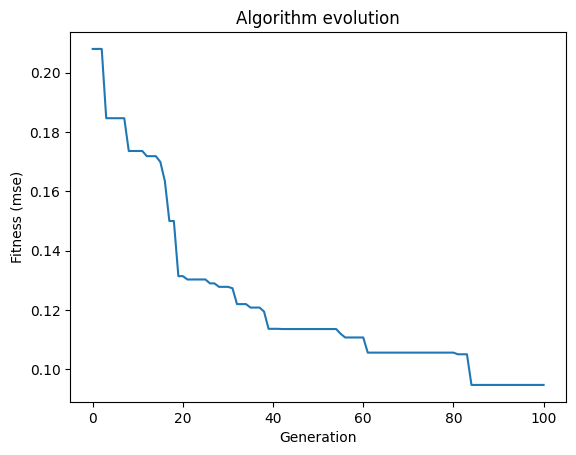

In [15]:
def VisualizaEvolucion(best_outputs):
    fig, ax = plt.subplots()
    ax.set_title("Algorithm evolution")
    plt.plot(best_outputs)
    plt.xlabel("Generation")
    plt.ylabel("Fitness (mse)")
    plt.show()
    
VisualizaEvolucion(estimador.best_outputs)

### Imprimir el modelo basado en reglas
- Los atributos se mostrarán mediante sus nombres.
- Los valores de los atributos categóricos se mostrarán mediante las etiquetas de sus clases.

In [16]:
def PrintRules(x,names):
    Sr,Sc,S,E = names    
    M = x.AL.shape[0]
    n = x.AL.shape[1]
    m = x.BB.shape[1]    
    for k in range(M):
        print("Rule ",k+1,":")
        s = ""
        primero = True
        for l in range(n):
            if x.aL[k][l]==1 or x.aU[k][l]==1:
                if primero:
                    primero = False
                else:
                    s += " AND "                        
                if x.aL[k][l]==1 and x.aU[k][l]==1: 
                    s += str(x.AL[k][l])+" <= "+str(Sr[l])+" <= "+str(x.AU[k][l])
                if x.aL[k][l]==1 and x.aU[k][l]==0: 
                    s += str(Sr[l])+" >= "+str(x.AL[k][l])
                if x.aL[k][l]==0 and x.aU[k][l]==1: 
                    s += str(Sr[l])+" <= "+str(x.AU[k][l])
        for l in range(m):
            if x.bB[k][l]:
                if primero:
                    primero = False
                else:
                    s += " AND "            
                s += str(Sc[l])+" is "+str(E[l][x.BB[k][l]])
        if not primero:
            s = "IF "+s+" THEN "
        s += S+" is "+str(x.S[k][0])
        print(s)
        
PrintRules(estimador.best_individuo.x,names)

Rule  1 :
IF 0.470191853569501 <= feature_0 <= 0.8158735443161679 AND 77.12301202354661 <= feature_1 <= 81.7221041867079 AND 1.6841006194881543 <= feature_2 <= 1.8079296449913245 AND feature_3 >= 1.4055020124586757 AND feature_4 <= 1.5016913548320843 AND feature_5 >= 1.3627266870773258 AND feature_6 <= 1.7500386619833408 AND feature_8 <= 1.7363374309868058 AND 198.57709536741908 <= feature_9 <= 222.03569176242377 AND feature_10 <= 159.23218494557463 AND feature_11 >= 1.3211382154500226 AND feature_12 <= 1.6321672038038422 AND 1.716011386598406 <= feature_13 <= 1.7264771185416419 AND feature_14 <= 1.7335455749617696 AND feature_15 <= 1.8269770857273415 AND feature_16 <= 1.6611411124307347 AND feature_17 >= 1.777125211136213 THEN target is 1.251334298408675
Rule  2 :
IF feature_2 >= 1.1667870567012706 AND 2.0748763388871048 <= feature_3 <= 2.467226448229042 AND 1.43246038486252 <= feature_5 <= 1.7247715612792824 AND feature_6 >= 1.0000123354604162 AND 1.511567801110583 <= feature_7 <= 1.

### Evaluación del estimador en k-fold cross-validation

In [19]:
n_splits=5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
resultado = np.sqrt(-cross_val_score(estimador, X=X, y=y, scoring='neg_mean_squared_error',cv=cv))
print('(%d)-fold RMSE = ' % n_splits, resultado)
print('(%d)-fold RMSE mean (std) = %s (%s)' % (n_splits, str(resultado.mean()), str(resultado.std())))

Generation: 100 RMSE: 0.276640 : : 101it [08:28,  5.04s/it]
Generation: 100 RMSE: 0.310581 : : 101it [07:06,  4.22s/it]
Generation: 100 RMSE: 0.318139 : : 101it [06:17,  3.74s/it]
Generation: 100 RMSE: 0.268366 : : 101it [05:47,  3.44s/it]
Generation: 100 RMSE: 0.327843 : : 101it [05:53,  3.50s/it]

(5)-fold RMSE =  [0.58074382 0.35297791 0.33877498 0.46217491 0.30701286]
(5)-fold RMSE mean (std) = 0.40833689401946655 (0.10078959950720914)


Generation: 100 RMSE: 0.276640 : : 101it [06:14,  3.71s/it]
Generation: 100 RMSE: 0.310581 : : 101it [06:08,  3.65s/it]
Generation: 100 RMSE: 0.318139 : : 101it [04:21,  2.59s/it]
Generation: 100 RMSE: 0.268366 : : 101it [03:50,  2.29s/it]
Generation: 100 RMSE: 0.327843 : : 101it [05:08,  3.05s/it]


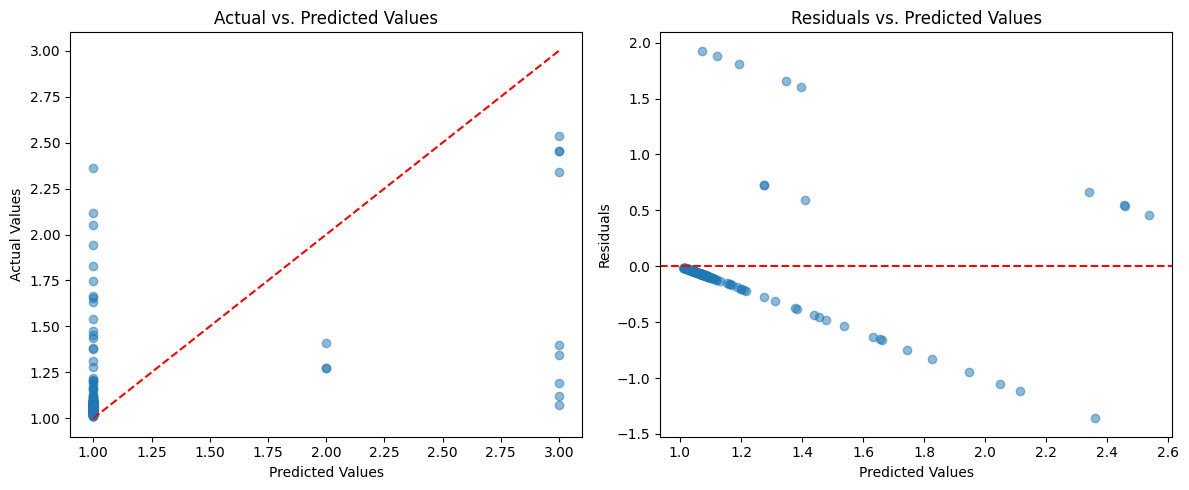

In [20]:
# Obtener predicciones de validación cruzada
y_pred = cross_val_predict(estimador, X, y, cv=cv)

# Crear la figura y los subgráficos
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Gráfica de "Actual vs. Predicted Values"
axs[0].scatter(y, y_pred, alpha=0.5)
axs[0].plot([min(y), max(y)], [min(y), max(y)], color="red", linestyle="--")
axs[0].set_title("Actual vs. Predicted Values")
axs[0].set_xlabel("Predicted Values")
axs[0].set_ylabel("Actual Values")

# Gráfica de "Residuals vs. Predicted Values"
residuals = y - y_pred
axs[1].scatter(y_pred, residuals, alpha=0.5)
axs[1].axhline(y=0, color="red", linestyle="--")
axs[1].set_title("Residuals vs. Predicted Values")
axs[1].set_xlabel("Predicted Values")
axs[1].set_ylabel("Residuals")

# Ajustar el diseño
plt.tight_layout()
plt.show()

### Evaluación del estimador en repeated k-fold cross-validation

In [ ]:
n_splits=5
n_repeats=2
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
resultado = np.sqrt(-cross_val_score(estimador, X=X, y=y, scoring='neg_mean_squared_error', cv=cv))
print('(%d)-fold repeat %d - RMSE mean (std) = ' % (n_splits, n_repeats), resultado)
print('(%d)-fold repeat %d - RMSE mean (std) = %s (%s)' % (n_splits, n_repeats, str(resultado.mean()), str(resultado.std())))

Generation: 100 RMSE: 0.276640 : : 101it [02:47,  1.66s/it]
Generation: 100 RMSE: 0.310581 : : 101it [02:48,  1.67s/it]
Generation: 100 RMSE: 0.318139 : : 101it [02:44,  1.63s/it]
Generation: 100 RMSE: 0.268366 : : 101it [02:45,  1.64s/it]
Generation: 100 RMSE: 0.327843 : : 101it [02:45,  1.64s/it]
Generation: 100 RMSE: 0.207795 : : 101it [02:47,  1.65s/it]
Generation: 100 RMSE: 0.335694 : : 101it [02:47,  1.66s/it]
Generation: 100 RMSE: 0.274151 : : 101it [02:47,  1.66s/it]
Generation: 100 RMSE: 0.345460 : : 101it [02:47,  1.66s/it]
Generation: 100 RMSE: 0.317896 : : 101it [02:48,  1.67s/it]

(5)-fold repeat 2 - RMSE mean (std) =  [0.58074382 0.35297791 0.33877498 0.46217491 0.30701286 0.60633128
 0.28987351 0.54587085 0.24300589 0.38713226]
(5)-fold repeat 2 - RMSE mean (std) = 0.41138982586926315 (0.12273321890204819)
